# Determining Sigma 10 & R 10 of DESIJ0201-2739

Author: Anowar Shajib, S M Rafee Adnan

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [2]:
data, header = fits.getdata("DESIJ0201-2739_F140W_drz_sci.fits", header=True)

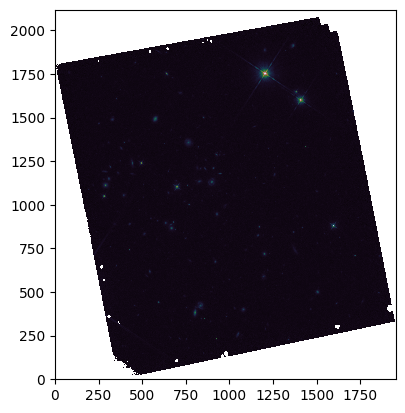

In [3]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


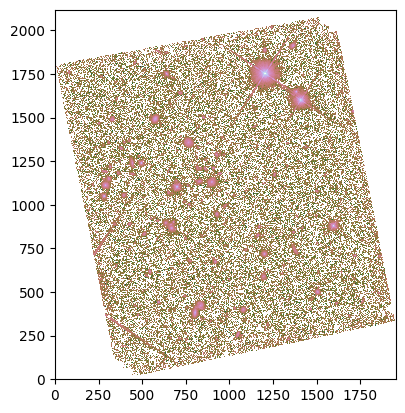

In [5]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [6]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.3398866643629581, 0.014041571279824873)

In [7]:
bkg_subtracted_data = data - bkg.background

In [8]:
threshold = 5 * bkg.background_rms

In [9]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [10]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [11]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2119, 1955)
nlabels: 427
labels: [  1   2   3   4   5 ... 423 424 425 426 427]


In [12]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 427
labels: [  1   2   3   4   5 ... 423 424 425 426 427]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [13]:
set_x_lim1, set_x_lim2 = 650, 1100
set_y_lim1, set_y_lim2 = 900, 1350

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/2408679973.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


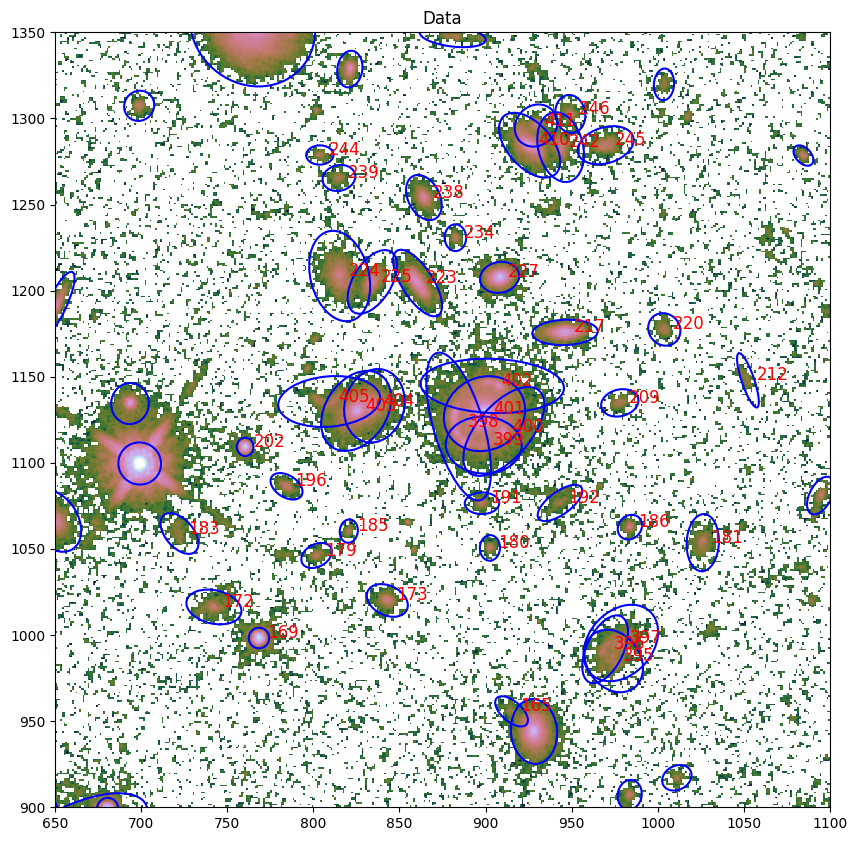

In [14]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

# Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 401
for i in range(len(cat)):
    if np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180 and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180:
      ax1.text(
          cat.xcentroid[i] + 5,
          cat.ycentroid[i],
          f"{i}",
          c="r",
          fontsize=12
      )

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/1989335250.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


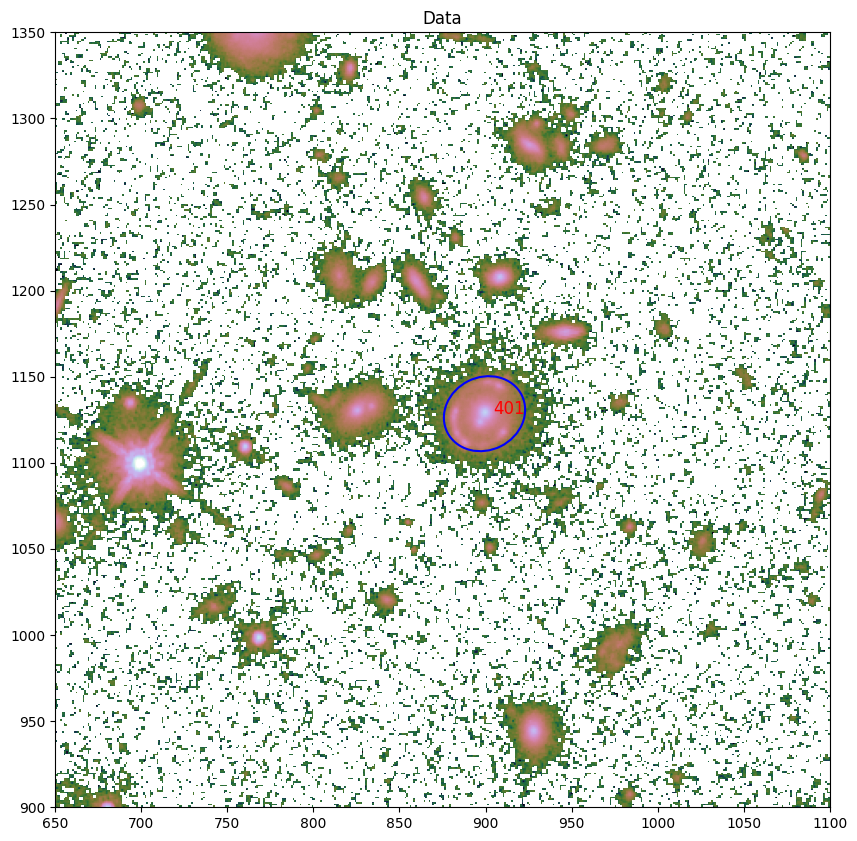

In [15]:
# object id of your central deflector/lens
id_central = 401

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [16]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [17]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:  #Find neighbouring galaxies within 20 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all))

Number of all close galaxies within 20 arcsecond radius: 52


In [18]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of close galaxies excluding dim sources within 20 arcsecond radius:", len(close_galaxies_1))

Number of close galaxies excluding dim sources within 20 arcsecond radius: 47


In [19]:
def distance_arcsec(pixel_distance):
    
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in arcsec unit

    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [20]:
# list of galaxies you want removed
remove_list = [401, #This is the central deflector
               402, # Object is part of the lensed arc
               398, # Object is part of the lensed arc
               399, # Object is part of the lensed arc
               400 # Object is part of the lensed arc
               ] 

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
191         52.040521          4.163242    5.734463    0.626565
404         64.088057          5.127045   68.183295    0.797643
217         66.450779          5.316062   88.626786    0.387379
192         67.898570          5.431886    7.171487    0.427570
403         74.518982          5.961519  152.589038    0.704933
180         78.005636          6.240451    4.402123    0.786626
209         78.795595          6.303648    6.234258    0.703051
227         79.623950          6.369916  115.565869    0.779900
223         85.231687          6.818535   70.300952    0.406073
405         90.434290          7.234743   27.144517    0.491968
225        100.491153          8.039292   32.369881    0.536542
234        103.570361          8.285629    4.521068    0.802093
185        104.206130          8.336490    2.943533    0.770842
186        107.100962          8.568077    6.611662    0.854675
220        115.284882          9.222791 

In [21]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
191         52.040521          4.163242    5.734463    0.626565
404         64.088057          5.127045   68.183295    0.797643
217         66.450779          5.316062   88.626786    0.387379
192         67.898570          5.431886    7.171487    0.427570
403         74.518982          5.961519  152.589038    0.704933
180         78.005636          6.240451    4.402123    0.786626
209         78.795595          6.303648    6.234258    0.703051
227         79.623950          6.369916  115.565869    0.779900
223         85.231687          6.818535   70.300952    0.406073
405         90.434290          7.234743   27.144517    0.491968
225        100.491153          8.039292   32.369881    0.536542
234        103.570361          8.285629    4.521068    0.802093
186        107.100962          8.568077    6.611662    0.854675
220        115.284882          9.222791    6.638923    0.909303
224        116.016156          9.281292 

## Determining Sigma 10, 20 and R 10, 20

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/257438462.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/257438462.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/257438462.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_27324/257438462.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


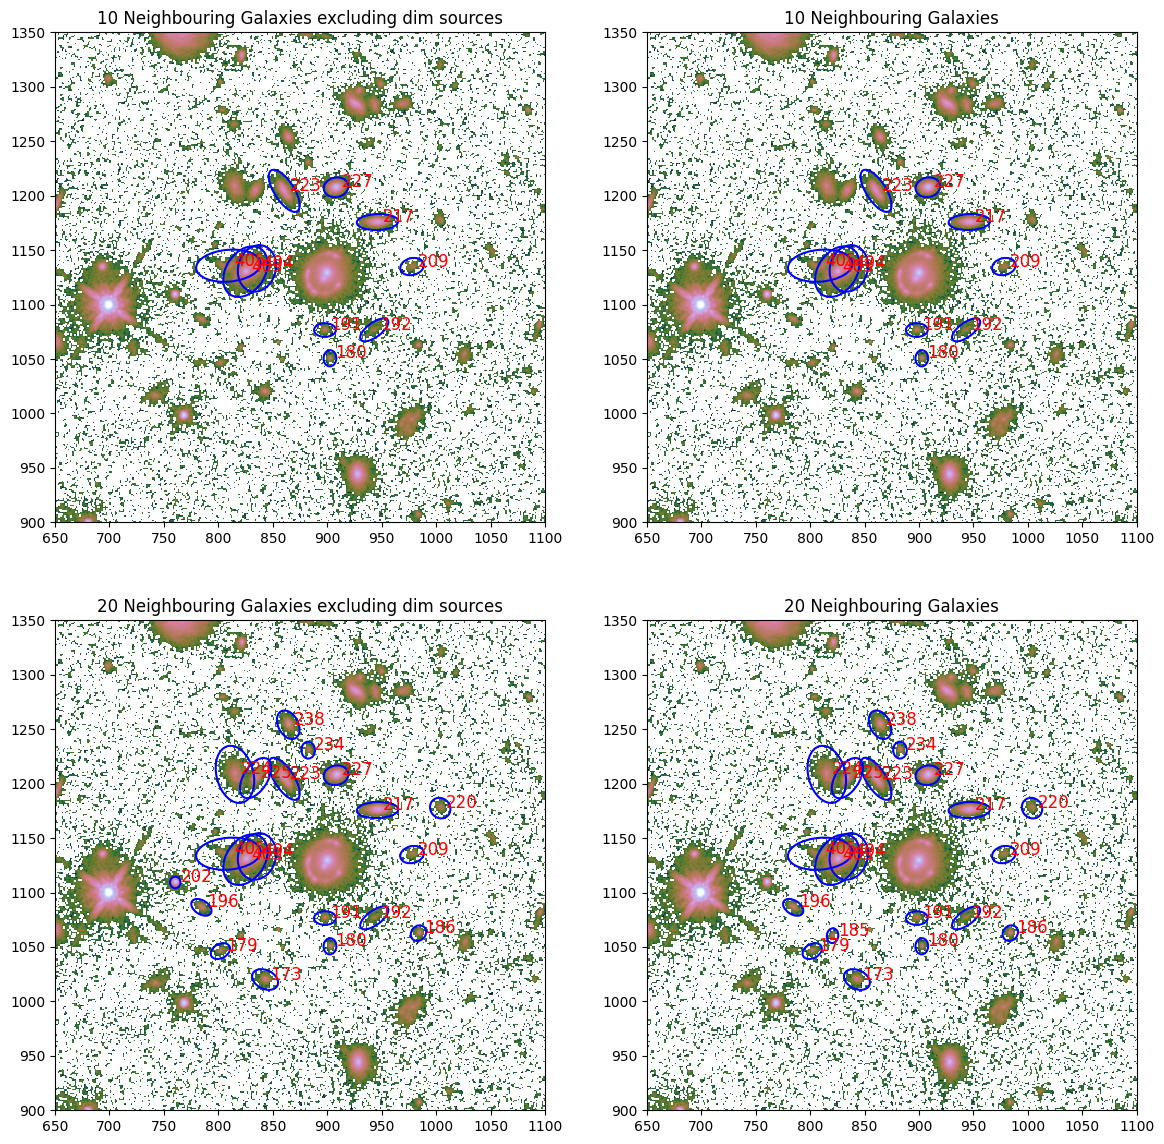

In [23]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

In [24]:
# One satellite galaxy (along 6 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# for both cases including and excluding dim sources.

R_10_1 = df_1_20.iloc[
    9 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19 - 1, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19 - 1, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)


EXCLUDING DIM SOURCES
R 10: 6.818534932092386
R 20: 10.426934133496347
Sigma 10: 0.06846490151100404
Sigma 20: 0.05855538795471809

FOR All SOURCES
R 10: 6.818534932092386
R 20: 10.209365231233406
Sigma 10: 0.06846490151100404
Sigma 20: 0.06107769539784787


## Save the final deriverables to the YAML file

In [25]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0201-2739_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [26]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.5792477330123961, 'Sigma_10': 0.06846490151100404, 'Sigma_10_flux_selected': 0.06846490151100404, 'Sigma_20': 0.06107769539784787, 'Sigma_20_flux_selected': 0.05855538795471809, 'center_x_light': [0.05721711389110907, 0.0008387203426047998, 0.0007750882628983491], 'center_x_mass': [0.08664244680557501, 0.006822737168431181, 0.008725020539451761], 'center_y_light': [0.12966197182300207, 0.0011059043143071268, 0.0009693531972206626], 'center_y_mass': [0.07234974808942285, 0.017823676375529673, 0.012353841726151026], 'gamma': [2.240508493685669, 0.0883990081189241, 0.1348647185715186], 'gamma_shear': [0.10447236670595668, 0.005753625683182578, 0.005644831096142319], 'phi_light': [-1.0149371576579749, 0.12662998909537104, 0.11841834485863845], 'phi_mass': [0.08457264108205767, 0.14943929126215938, 0.18786944477282763], 'phi_shear': [-0.8553746108427701, 0.01348129643204321, 0.014793859401723508], 'q_light': [0.9611579487863346, 0.0056634946